## Step 1 - Reading and cleaning the data

In [289]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data_file_names = os.listdir("data")
print(f"There are {len(data_file_names)} matches stored in the data folder, which will be used to train my model")

There are 135 matches stored in the data folder, which will be used to train my model


Next, I will wriite a function to read in all of the matches and combine them into one dataset

In [290]:
def read_in_matches(data_location: str='data') -> pd.DataFrame:
    """
    Desc: A function to read in all of the match data files and combined them into one
          pandas dataframe
    Params:
        data_location (string) - The location of the folder containing the match data
    Returns:
        pd.DataFrame - A dataframe containing the combined match data                          
    """
    parts = []
    for file_location in os.listdir(data_location):
        parts.append(pd.read_csv(f"{data_location}/{file_location}"))
    return pd.concat(parts, axis=0).reset_index()

all_matches = read_in_matches()
all_matches.sample(5)

,index,gameMap,gameMode,id,programId,firstName,lastName,alias,headshot,socialNetworkHandles,...,matchGameResult.guestGameScore,matchGameResult.winnerTeamId,matchGameResult.loserTeamId,homeTeamGamesWon,awayTeamGamesWon,winnerTeamId,loserTeamId,matchDate,totalHeadshots,totalTiersCaptured
783,15,El Asilo,CDL SnD,517,2,Thomas,Ernst,Scrap,https://www.callofduty.com/content/dam/activis...,[],...,6.0,17.0,7.0,1,3,17,7,2023-04-02T23:54:45.240Z,NaN,NaN
3529,33,Al Bagra Fortress,CDL SnD,46,2,James,Eubanks,Clayster,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",...,6.0,15.0,12.0,2,3,15,12,2023-04-02T23:54:45.240Z,NaN,NaN
840,40,El Asilo,CDL Control,65,2,Tobias Juul,Jønsson,CleanX,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",...,2.0,17.0,6.0,4,2,17,6,2023-04-02T23:54:45.240Z,NaN,NaN
3864,0,Mercado Las Almas,CDL Hardpoint,44,2,Obaid,Asim,Asim,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",...,250.0,69.0,10.0,0,3,69,10,2023-04-02T23:54:45.240Z,NaN,NaN
2698,2,Al Bagra Fortress,CDL Hardpoint,36,2,Cameron,McKilligan,Cammy,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",...,246.0,12.0,7.0,3,0,12,7,2023-04-02T23:54:45.240Z,NaN,NaN


In order to be able to determine who the winner of a map is from my model, I must first add a new column to the current dataset that clearly indicates who won the map (In call of duty, 1 map = one game, 5 maps = series. This follows the commonly used best of 5 format). This will also be known as the label in my model

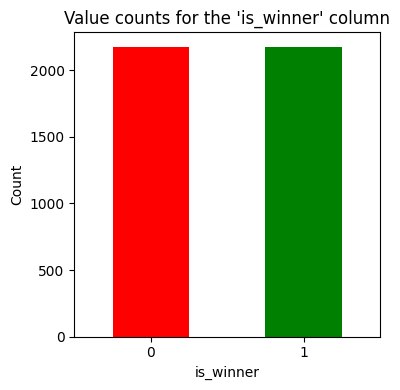

In [291]:
def declare_winner(df: pd.DataFrame) -> pd.DataFrame:
    """
    Desc: A function to add a new variable to a dataframe indicating if that player
          won the 'map'
    """
    df['map_winner'] = ["host" if a > b else "guest" for a, b in zip(df['matchGameResult.hostGameScore'], df['matchGameResult.guestGameScore'])]
    df['is_winner'] = [1 if a == b else 0 for a, b in zip(df['map_winner'], df['team_type'])]
    # The map_winner column can be dropped in the returned df because it is only needed to determine our label (the is_winner column)
    df.drop('map_winner', axis=1, inplace=True)
    return df


def plot_value_counts(df: pd.DataFrame, variable: str, axis: plt.axis, colors: list=None) -> None:
    """
    Desc: A function to plot value counts for a column onto a given axis
    """
    if colors:
        df[variable].value_counts().plot(kind='bar', ax=axis, color=colors)
    else:
        df[variable].value_counts().plot(kind='bar', ax=axis)
    
    ax1.tick_params(rotation=0)
    ax1.set_ylabel("Count")
    ax1.set_title(f"Value counts for the '{variable}' column")

winners_df = declare_winner(all_matches)

fig = plt.figure(figsize=(4, 4), layout='tight')
ax1 = fig.subplots()

plot_value_counts(winners_df, 'is_winner', ax1, ['red', 'green'])

The graph shows an equal number of winners and losers, which is expected as both teams have the same number of players, therefore meaning each map should have 4 winners and 4 losers.  

Next I will convert reduce the number of columns in the data as it is evident that there are too many. the columns that I select will be the ones that are relevant in determining the winner of a Hardpoint map

In [292]:
# Display all of the columns in the dataset
all_matches.columns.values

array(['index', 'gameMap', 'gameMode', 'id', 'programId', 'firstName',
       'lastName', 'alias', 'headshot', 'socialNetworkHandles',
       'averageSpeed', 'highestStreak', 'untradedKills', 'untradedDeaths',
       'tradedKills', 'tradedDeaths', 'inapplicableTradedKills',
       'inapplicableTradedDeaths', 'damageTaken', 'damageHealed',
       'tacticalsUsed', 'lethalsUsed', 'percentTimeMoving',
       'deadSilenceTime', 'hillTime', 'contestedHillTime',
       'esportsTournamentId', 'totalKills', 'totalDeaths', 'totalAssists',
       'totalScore', 'totalShotsFired', 'totalShotsHit', 'totalShotsHead',
       'totalDamageDealt', 'friendDamage', 'totalTimeAlive',
       'totalDistanceTraveled', 'highestMultikill', 'totalAces',
       'totalInVictimFovKills', 'totalDefuserKills',
       'totalFirstBloodKills', 'totalLongshotKills', 'totalPlanterKills',
       'totalPointblankKills', 'totalRevengeKills', 'totalRotationKills',
       'totalInAttackerFovKills', 'totalWallbangKills', 'killDe

In [293]:
needed_columns = ['totalKills', 'totalDeaths', 'totalRotationKills', 'is_winner', 'abbrev', 'totalDamageDealt', 'damageTaken', 'tradedDeaths', 'tradedKills', 'untradedKills', 'untradedDeaths',
                  'matchGame.matchId', 'gameMode', 'gameMap']
# Column Descriptions
# totalKills - The total number of kills a player has in a map
# totalDeaths - The total number of deaths a player has in a map
# totalRotationKills - The total number of kills a player has while rotating to the new hardpoint/hill
# is_winner - Whether or not the player won that map (1=Yes, 0=No)
# totalDamageDealt - The total number of damage a player has dealt in a map
# damageTaken - The total number of damage a player has taken in a map
# tradedDeaths - The total number of deaths a player has in a map that were traded (their teammate killed the person who killed- 
#                them (player) shortly after they died)
# tradedKills - The total number of times a player has died shortly after getting a kill
# untradedKills - The total number of kills a player has where he wasn't killed afterwards in a short amount of time
# untradedDeaths - The total number of deaths a player has where their teammates failed to 'avenge' them shortly after
# matchGame.matchId - The ID for the match, used to ensure groupings are consistent to the same map and game (when grouping up-
#                     to teams)
# gameMode - The gameMode of the map played by the player
# gameMap - The name of the map played by the player

refined_df = winners_df[needed_columns]
refined_df.sample(5)

,totalKills,totalDeaths,totalRotationKills,is_winner,abbrev,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths,matchGame.matchId,gameMode,gameMap
2468,16.0,18.0,0.0,1,SEA,2163.0,2114.0,8.0,7.0,8.0,10.0,8706,CDL Control,Al Bagra Fortress
3901,5.0,8.0,0.0,1,FLA,1049.0,1577.0,1.0,0.0,4.0,5.0,8762,CDL SnD,Embassy
2589,19.0,15.0,0.0,1,ATL,2415.0,1948.0,6.0,5.0,13.0,9.0,8709,CDL Control,Breenbergh Hotel
2768,21.0,22.0,0.0,0,ATL,3072.0,2855.0,6.0,5.0,16.0,16.0,8715,CDL Control,Breenbergh Hotel
1465,10.0,6.0,0.0,1,FLA,1271.0,786.0,0.0,2.0,8.0,5.0,8650,CDL SnD,El Asilo


Now that I have reduced the number of columns in the data, I will group the data by team for each individual map that team has played, which allows for teams to be compared rather than players. This is essential for the model to work correctly as it must have data for complete teams rather than individual players.  
The data will be specifically grouped by abbrev, matchGame.matchId, gameMap and gameMode. This will ensure that each row represents a singular map played. Abbrev will group by team, matchGame.matchId will group by the match (best of 5) itself, gameMap will group by the name of the map being played and gameMode will group by the mode of that map (the same map and mode combo can't be played twice in one series)

In [294]:
# Group the data down to individual maps played
grouping_vars = ['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode']
team_df = refined_df.groupby(grouping_vars).sum()
team_df.sample(5)

,,,,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
abbrev,matchGame.matchId,gameMap,gameMode,,,,,,,,,,
LAT,10113,El Asilo,CDL Control,34.0,61.0,0.0,0,4832.0,6979.0,9.0,16.0,18.0,52.0
SEA,8771,El Asilo,CDL Control,88.0,79.0,0.0,4,11579.0,9951.0,16.0,15.0,74.0,63.0
LAG,10117,Breenbergh Hotel,CDL Hardpoint,74.0,90.0,16.0,0,9785.0,11218.0,22.0,19.0,55.0,69.0
ATL,10888,Embassy,CDL Hardpoint,101.0,88.0,18.0,4,11948.0,11503.0,34.0,21.0,80.0,54.0
NY,8649,Al Bagra Fortress,CDL Hardpoint,111.0,99.0,21.0,0,13200.0,0.0,0.0,0.0,0.0,0.0


To ensure that the is_winner column (my label) remains binary, I must ensure that instances where a team has won the map appear as 1 and not 4

In [295]:
# Replace 4 with 1 in the is_winner column
team_df['is_winner'] = [og if og == 0 else 1 for og in team_df['is_winner']]
print(f"The unqiue values in the is_winner column are: {team_df['is_winner'].unique()}")

The unqiue values in the is_winner column are: [1 0]


Now that this issue has been resolved within the data, I can filter the data to only include the hardpoint gamemode, as this is the gamemode that I am trying to predict the outcome of.

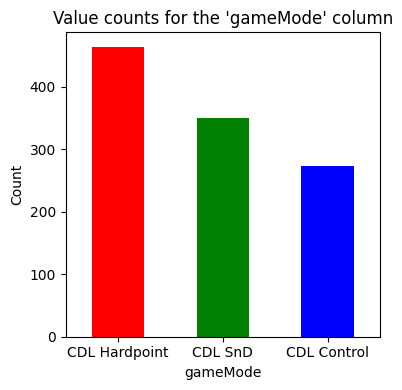

In [296]:
# Reset the index so that columns used in grouping remain as column
team_df.reset_index(inplace=True)

# Plot value counts for the game modes
fig = plt.figure(figsize=(4, 4), layout='tight')
ax1 = fig.subplots()
plot_value_counts(team_df, 'gameMode', ax1, ['red', 'green', 'blue'])

From the value counts, we can see that Hardpoint is the majority gamemode, meaning that we will still have a large amount of data to work from after removing the other two gamemodes from the dataset.

In [297]:
# Create a dataset with only the hardpoint data
hp_df = team_df.copy()[team_df['gameMode']=='CDL Hardpoint'].reset_index(drop=True)
print(f"The unqiue values in the gameMode column are: {hp_df['gameMode'].unique()}")

The unqiue values in the gameMode column are: ['CDL Hardpoint']


Now that I have manipulated our dataset to only show the relevant data for the creation of my model, I can look at removing anomalies and further cleaning the data. Firstly, I will look at plotting variable against eachother to determine if there are any obvious outliers. I will plot variables that have a significant relationship (in terms of the game itself) to begin with 

<Axes: xlabel='untradedKills', ylabel='tradedKills'>

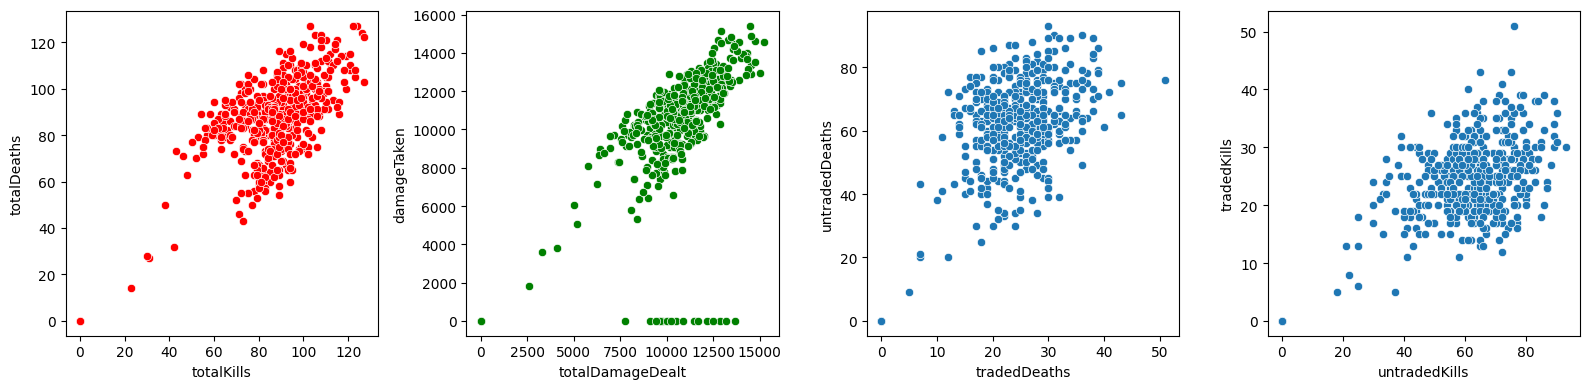

In [298]:
import seaborn as sns
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=hp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=hp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=hp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=hp_df, x='untradedKills', y='tradedKills', ax=ax4)

From the first graph, it can be seen that some there are games with 0 kills and 0 deaths

In [299]:
hp_df[hp_df['totalKills']==0]

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
57,BOS,8712,Embassy,CDL Hardpoint,0.0,0.0,19.0,1,0.0,0.0,0.0,0.0,0.0,0.0
430,TX,8712,Embassy,CDL Hardpoint,0.0,0.0,15.0,0,0.0,0.0,0.0,0.0,0.0,0.0


As there this is a very small number of rows, I have decided that these rows can be dropped. They are also both from the same match/map

In [300]:
# Drop rows where there aren't any kills
hp_df = hp_df[hp_df['totalKills'] > 0]

# Games where there are an unusually small number of kills and deaths
hp_df[hp_df['totalKills'] <= 45]

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
186,LAT,8766,Zarqwa Hydroelectric,CDL Hardpoint,42.0,32.0,19.0,1,5180.0,5042.0,12.0,5.0,37.0,20.0
203,LDN,8643,Breenbergh Hotel,CDL Hardpoint,43.0,73.0,10.0,0,5771.0,8105.0,18.0,18.0,25.0,55.0
364,SEA,8766,Zarqwa Hydroelectric,CDL Hardpoint,38.0,50.0,8.0,0,5039.0,6034.0,7.0,13.0,25.0,43.0
366,SEA,8767,Zarqwa Hydroelectric,CDL Hardpoint,31.0,27.0,25.0,1,4120.0,3798.0,7.0,6.0,25.0,20.0
404,TOR,8767,Zarqwa Hydroelectric,CDL Hardpoint,30.0,28.0,22.0,0,3308.0,3614.0,7.0,8.0,22.0,21.0
443,TX,8775,Mercado Las Almas,CDL Hardpoint,23.0,14.0,20.0,1,2609.0,1843.0,5.0,5.0,18.0,9.0


I will now investigate these instances and identify where the problem is

In [301]:
# Test Case 1 - Match 8766
match_8766 = all_matches[all_matches['matchGame.matchId']==8766]
match_8766[match_8766['gameMode']=='CDL Hardpoint'][['alias', 'gameMap', 'totalKills', 'totalDeaths']]

,alias,gameMap,totalKills,totalDeaths
4024,Accuracy,Zarqwa Hydroelectric,24.0,26.0
4025,Kenny,Zarqwa Hydroelectric,21.0,13.0
4026,Mack,Zarqwa Hydroelectric,0.0,0.0
4027,Octane,Zarqwa Hydroelectric,0.0,0.0
4028,Sib,Zarqwa Hydroelectric,0.0,0.0
4029,Envoy,Zarqwa Hydroelectric,0.0,0.0
4030,Pred,Zarqwa Hydroelectric,14.0,24.0
4031,Drazah,Zarqwa Hydroelectric,21.0,19.0
4048,Accuracy,Embassy,22.0,23.0
4049,Kenny,Embassy,22.0,18.0


In [302]:
# Test Case 2 - Match 8767
match_8767 = all_matches[all_matches['matchGame.matchId']==8767]
match_8767[match_8767['gameMode']=='CDL Hardpoint'][['alias', 'gameMap', 'totalKills', 'totalDeaths']]

,alias,gameMap,totalKills,totalDeaths
4056,Accuracy,Zarqwa Hydroelectric,0.0,0.0
4057,CleanX,Zarqwa Hydroelectric,30.0,28.0
4058,Mack,Zarqwa Hydroelectric,0.0,0.0
4059,Insight,Zarqwa Hydroelectric,0.0,0.0
4060,Sib,Zarqwa Hydroelectric,31.0,27.0
4061,Hicksy,Zarqwa Hydroelectric,0.0,0.0
4062,Pred,Zarqwa Hydroelectric,0.0,0.0
4063,Scrap,Zarqwa Hydroelectric,0.0,0.0
4080,Accuracy,Al Bagra Fortress,21.0,23.0
4081,CleanX,Al Bagra Fortress,35.0,23.0


It can be seen from the test cases that some players were not having their statistics recorded correctly. I will also drop these cases from the dataset (totalKills <= 40>)

<Axes: xlabel='untradedKills', ylabel='tradedKills'>

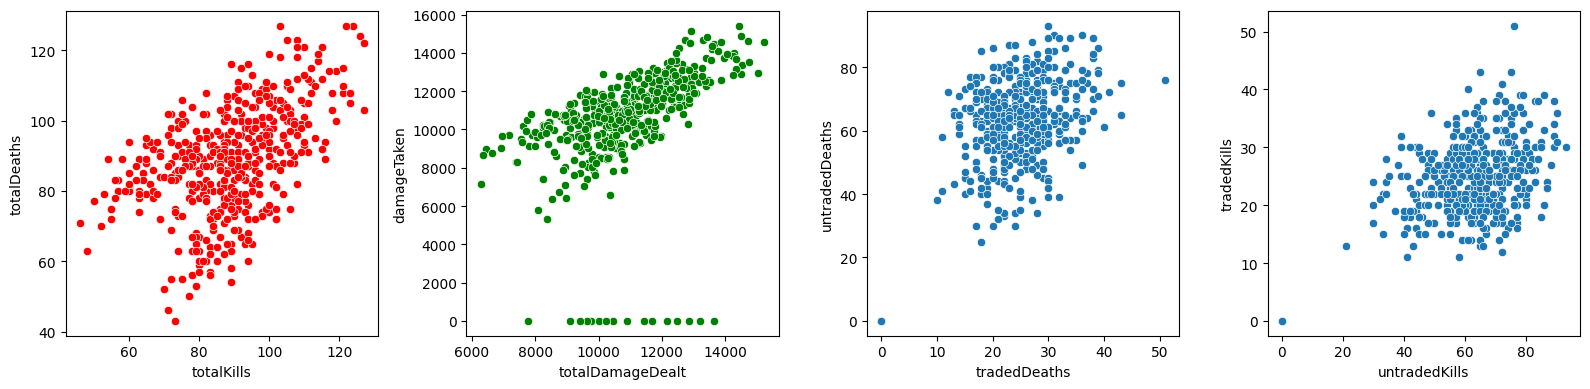

In [303]:
# Remove rows with missing data
hp_df = hp_df[hp_df['totalKills']>45]

# Re-plot graphs
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=hp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=hp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=hp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=hp_df, x='untradedKills', y='tradedKills', ax=ax4)

Moving on to the second plot, I can clearly see that there are a large number of maps where a teams damageTaken is 0, while there totalDamageDealt remains correct. To impute these values, I will take the average damage delta (totalDamageDealt-damageTaken) in both a win and a loss and add that to the damageTaken.  
E.g.,  
Damage Dealt = 1000, Damage Taken = 1050 (for a loss)
If the average damage delta is then -50 for a loss, damageTaken for each loss (where there is missing data) will be imputed as totalDamageDealt - (-50)  
I will first determine whether or not to use mean or median as the 'average' whilst imputing by plotting the normal distributions for both winners and losers

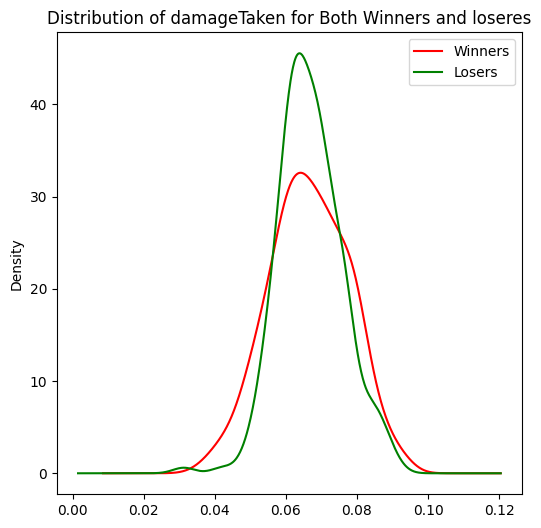

In [304]:
# Import required libraries
from sklearn.preprocessing import normalize
import numpy as np

# Separate df into dfs for winners and losers
df_winners = hp_df.copy()[hp_df['is_winner']==1]
df_losers = hp_df.copy()[hp_df['is_winner']==0]

# Plot normal distributions

fig = plt.figure(figsize=(6, 6))
ax1 = fig.subplots()

valid_damage_w = df_winners[df_winners['damageTaken']>0]['damageTaken']
norm_data_w = normalize(np.array(valid_damage_w).reshape(1, -1))
pd.Series(norm_data_w[0]).plot.density(ax=ax1, label='Winners', color='red')

valid_damage_l = df_losers[df_losers['damageTaken']>0]['damageTaken']
norm_data_l = normalize(np.array(valid_damage_l).reshape(1, -1))
pd.Series(norm_data_l[0]).plot.density(ax=ax1, label='Losers', color='green')

ax1.legend(loc='upper right')
ax1.set_title("Distribution of damageTaken for Both Winners and loseres");


From the above plot, I have determined that the mean can be used as an average as the disribution isn't extremely skewed

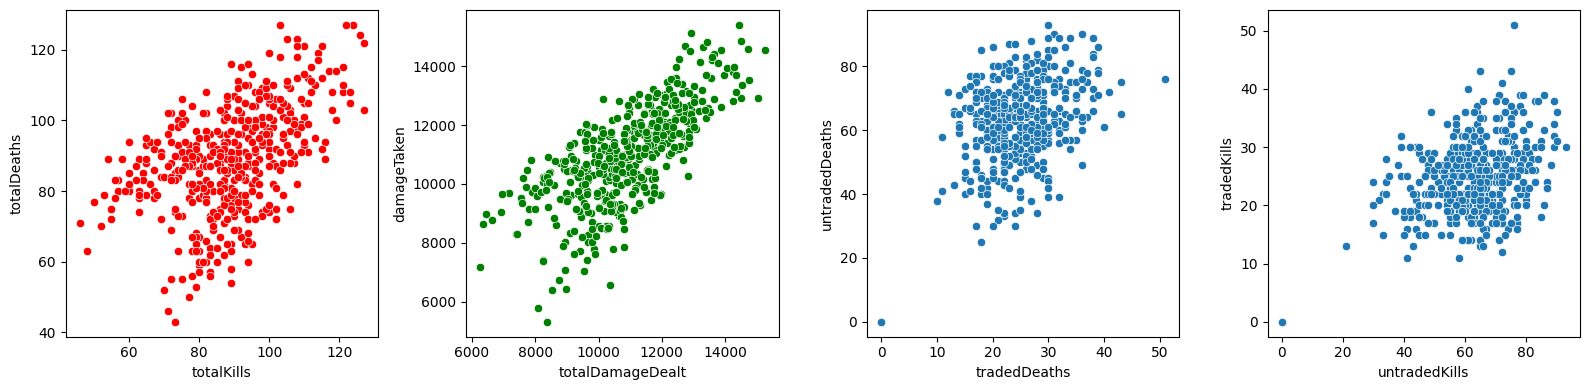

In [305]:
def impute_damage_taken(df):
    """
    Desc: A function to impute the damageTaken if damageTaken = 0 
    """
    clean_data = df.copy()[df['damageTaken']>0]
    clean_data['damageDelta'] = clean_data['totalDamageDealt']-clean_data['damageTaken']
    average = clean_data['damageDelta'].mean()
    df['damageTaken'] = [og if og != 0 else dealt-average for og, dealt in zip(df['damageTaken'], df['totalDamageDealt'])]
    return df

# Separate the data into two dfs for winners and losers
df_winners = impute_damage_taken(df_winners)
df_losers = impute_damage_taken(df_losers)

# Combined both dfs now that damageTaken has been imputed
damage_imp_df = pd.concat([df_winners, df_losers], axis=0)

# Plot the results
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=damage_imp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=damage_imp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=damage_imp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=damage_imp_df, x='untradedKills', y='tradedKills', ax=ax4);

It is clear that this method has worked in removing certain anomalies from the data. Moving on to the next graph, I can see that there are instances where there are no tradedDeaths or untradedDeaths being recorded. Because this data can not be imputed (as they are opposites), the rows will be dropped. 

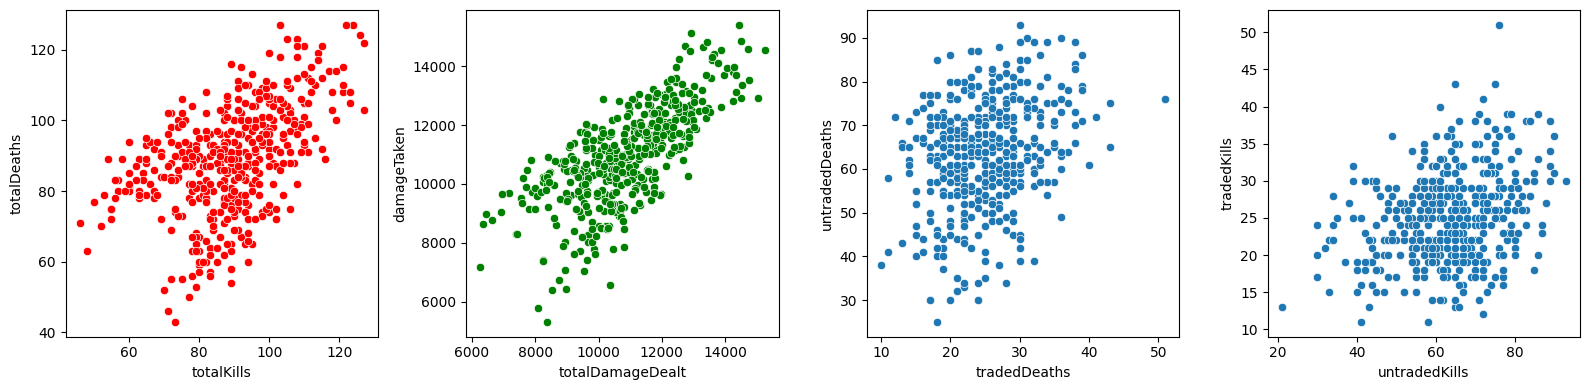

In [306]:
# Remove instances where tradedDeaths == 0
damage_imp_df = damage_imp_df[damage_imp_df['tradedDeaths']>0]

# Plot Results
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=damage_imp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=damage_imp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=damage_imp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=damage_imp_df, x='untradedKills', y='tradedKills', ax=ax4);

Looking at the final graph, I can see that there aren't issues where untradedKills/tradedKills == 0, therefore I will leave this data is it is.

In [307]:
# Display a list of columns in the data
damage_imp_df.columns.values

array(['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode', 'totalKills',
       'totalDeaths', 'totalRotationKills', 'is_winner',
       'totalDamageDealt', 'damageTaken', 'tradedDeaths', 'tradedKills',
       'untradedKills', 'untradedDeaths'], dtype=object)

In [308]:
columns_to_drop = ['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode']

# Reasons for dropping each column
# abbrev - This is no longer required as we don't want our model to be biased towards any
#          individual teams
# matchGame.matchId - This is no longer needed as we don't need to know what match each
#                     row of data is from
# gameMap - We no longer need the map as we are only predicting the winner of a harpdoint
#           game, not map specific
# gameMode - We no longer need the gameMode column as we know that the only gamemode 
#            included in the data is hardpoint

# Drop the columns that aren't needed
damage_imp_df.drop(columns_to_drop, axis=1, inplace=True)
print(f"The remaining columns in the dataset are: {damage_imp_df.columns.values}")
damage_imp_df.sample(5)


The remaining columns in the dataset are: ['totalKills' 'totalDeaths' 'totalRotationKills' 'is_winner'
 'totalDamageDealt' 'damageTaken' 'tradedDeaths' 'tradedKills'
 'untradedKills' 'untradedDeaths']


,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
8,63.0,89.0,14.0,0,8416.0,10907.0,20.0,18.0,46.0,69.0
286,83.0,56.0,13.0,1,9848.0,7802.0,22.0,16.0,67.0,34.0
391,77.0,91.0,12.0,0,9611.0,10673.0,22.0,20.0,57.0,69.0
239,92.0,86.0,17.0,1,10963.0,10582.0,30.0,24.0,68.0,56.0
274,108.0,118.0,26.0,0,12895.0,14535.0,43.0,26.0,82.0,75.0


In [309]:
print(f"The shape of the data has changed from {all_matches.shape} to {damage_imp_df.shape}\nThis is a change of {all_matches.shape[0]-hp_df.shape[0]} rows and {all_matches.shape[1]-damage_imp_df.shape[1]} columns")

The shape of the data has changed from (4352, 104) to (440, 10)
This is a change of 3896 rows and 94 columns


Now that the data has been cleaned, I will take a final look at the data to ensure that there is no unclean data still in the dataset.

In [310]:
print(f"There are {damage_imp_df.isna().sum().sum()} NULLs in the data\n")
damage_imp_df.info();

There are 0 NULLs in the data

<class 'pandas.core.frame.DataFrame'>
Index: 440 entries, 0 to 455
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   totalKills          440 non-null    float64
 1   totalDeaths         440 non-null    float64
 2   totalRotationKills  440 non-null    float64
 3   is_winner           440 non-null    int64  
 4   totalDamageDealt    440 non-null    float64
 5   damageTaken         440 non-null    float64
 6   tradedDeaths        440 non-null    float64
 7   tradedKills         440 non-null    float64
 8   untradedKills       440 non-null    float64
 9   untradedDeaths      440 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 37.8 KB


Before beginning to analyse the data, I will create some new variables from the pre-existing variable to remove bias that could be introduced by nor normalizing the data between different maps. For example, one map could on average have more kills per game than anotherm, therefore each statistic should be represented as a percentage (excl. damage). An example of this is removing totalKills and totalDeaths and using K/D ratio (totalKills/totalDeaths)

In [311]:
damage_imp_df['kd'] = damage_imp_df['totalKills']/damage_imp_df['totalDeaths']
damage_imp_df['percRotationKills'] = damage_imp_df['totalRotationKills']/damage_imp_df['totalKills']
damage_imp_df['percTradedDeaths'] = damage_imp_df['tradedDeaths']/damage_imp_df['totalDeaths']
damage_imp_df['percUntradedDeaths'] = damage_imp_df['untradedDeaths']/damage_imp_df['totalDeaths']
damage_imp_df['percTradedKills'] = damage_imp_df['tradedKills']/damage_imp_df['totalKills']
damage_imp_df['percUntradedKills'] = damage_imp_df['untradedKills']/damage_imp_df['totalKills']
damage_imp_df['damageDelta'] = damage_imp_df['totalDamageDealt']-damage_imp_df['damageTaken']

required_columns = ['kd', 'percRotationKills', 'percTradedDeaths', 'percUntradedDeaths', 'percTradedKills', 'percUntradedKills', 'damageDelta', 'is_winner']

cleaned_df = damage_imp_df.copy()[required_columns]
cleaned_df.sample(3)

,kd,percRotationKills,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
375,0.702128,0.181818,0.276596,0.723404,0.378788,0.621212,-2169.0,0
27,0.951220,0.230769,0.292683,0.707317,0.294872,0.705128,-406.0,0
162,0.767241,0.191011,0.267241,0.732759,0.337079,0.662921,-1814.0,0


## Step 2 - Data Analysis  
#### In order to better understand the data, I will look at the extremes, the relationships between variables and the differences between different rows.  


To begin with, I will plot a correlation matrix which should allow me to understand the relationships between variables. This may also help me get an idea of how many columns to remove using PCA later on. I will be measuring correlation using spearman correlation as the data is not normalised

In [312]:
cleaned_df.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,kd,percRotationKills,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
kd,1.000000,-0.044672,0.505023,-0.494165,-0.496156,0.493464,0.913437,0.788753
percRotationKills,-0.044672,1.000000,-0.115569,0.122199,-0.007906,0.009296,-0.026790,-0.085978
percTradedDeaths,0.505023,-0.115569,1.000000,-0.980394,-0.093246,0.103940,0.413369,0.387286
percUntradedDeaths,-0.494165,0.122199,-0.980394,1.000000,0.113949,-0.090422,-0.431818,-0.383885
percTradedKills,-0.496156,-0.007906,-0.093246,0.113949,1.000000,-0.971668,-0.428143,-0.382616
percUntradedKills,0.493464,0.009296,0.103940,-0.090422,-0.971668,1.000000,0.401276,0.384370
damageDelta,0.913437,-0.026790,0.413369,-0.431818,-0.428143,0.401276,1.000000,0.733798
is_winner,0.788753,-0.085978,0.387286,-0.383885,-0.382616,0.384370,0.733798,1.000000


At first glance, I can see that the 'percRotationKills' variable not only has little correlation to is_winner (what we're trying to predict), but it also doesn't have much correlation to the other variables in the dataset. Because of this, I will be dropping the column from the data.

In [313]:
# Drop column percRotationKills
cleaned_df.drop("percRotationKills", axis=1, inplace=True);

It is also clear that the two most correlated variable to is_winner are damageDelta and kd. Because of this, I will plot them against eachother to observe the relationship

In [314]:
# Plot correltaion matrix for damageDelta, is_winner and kd
cleaned_df.copy()[['kd', 'is_winner', 'damageDelta']].corr(method='spearman').style.applymap(lambda x: "background-color:red" if x > 0.8 else "background-color:orange;color:black")

,kd,is_winner,damageDelta
kd,1.000000,0.788753,0.913437
is_winner,0.788753,1.000000,0.733798
damageDelta,0.913437,0.733798,1.000000


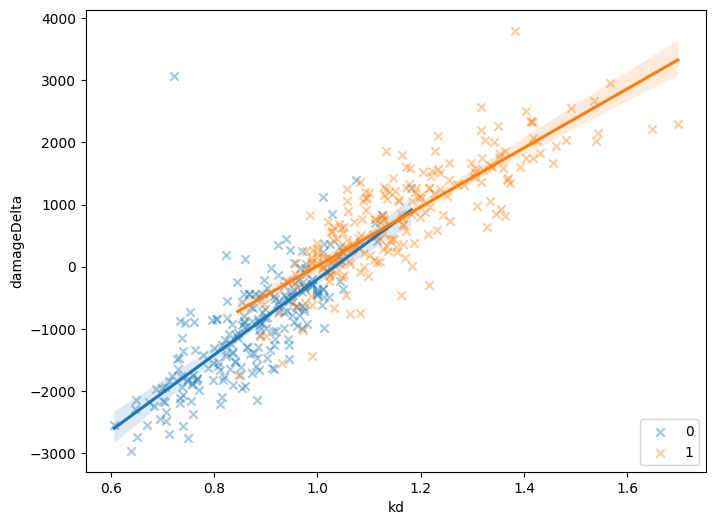

In [315]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.subplots()
for outcome in [0, 1]:
    sns.regplot(ax=ax1, data=cleaned_df[cleaned_df['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome)
ax1.legend(loc="lower right");

It is evident that there is one outlier for a losing team, where their damageDelta is extremely positive despite having an extremely low KD.

In [316]:
cleaned_df[cleaned_df['damageDelta']> 3000]

,kd,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
347,1.382353,0.308824,0.514706,0.202128,0.457447,3797.0,1
426,0.723404,0.106383,0.404255,0.191176,0.308824,3070.0,0


In [317]:
# Create a copy of the team dataframe so that the correct game can be found
testing_df = team_df.copy()
testing_df['kd'] = testing_df['totalKills']/testing_df['totalDeaths']

# Narrow down the dataframe to find the game because of rounding errors
testing_df = testing_df[testing_df['kd'] > 0.723400]
testing_df = testing_df[testing_df['kd'] < 0.72342]
testing_df

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths,kd
997,TX,8691,Breenbergh Hotel,CDL Hardpoint,68.0,94.0,13.0,0,8383.0,5313.0,10.0,13.0,21.0,38.0,0.723404


I can see that the anomaly is from one of OpTic Texas' (TX) games, with match ID 8691, on Breenbergh Hotel.

In [318]:
# Select the relevant map and the relevant columns
match_8691 = all_matches[all_matches['matchGame.matchId']==8691]
hotel_8691 = match_8691[match_8691['gameMap']=='Breenbergh Hotel']
hotel_8691[['alias', 'totalDamageDealt', 'damageTaken', 'totalKills', 'totalDeaths']]

,alias,totalDamageDealt,damageTaken,totalKills,totalDeaths
2000,Shotzzy,1957.0,2424.0,18.0,22.0
2001,Accuracy,1896.0,1970.0,14.0,18.0
2002,iLLeY,2164.0,NaN,16.0,21.0
2003,Mack,2231.0,2536.0,20.0,23.0
2004,Huke,2283.0,NaN,18.0,25.0
2005,Sib,3117.0,NaN,32.0,12.0
2006,Dashy,1979.0,2889.0,16.0,26.0
2007,Pred,3114.0,2055.0,28.0,15.0


Here I can see that there are NULL values for the individual damageTaken for different players (iLLey, Huke and Sib). Because of the small sample that this issue impacts (2 rows), I will remove this row from the dataset. This impacts 2 rows because there are NULLs on each team. The other row which it impacts also appears as an outlier on the plots showing kd vs damageDelta

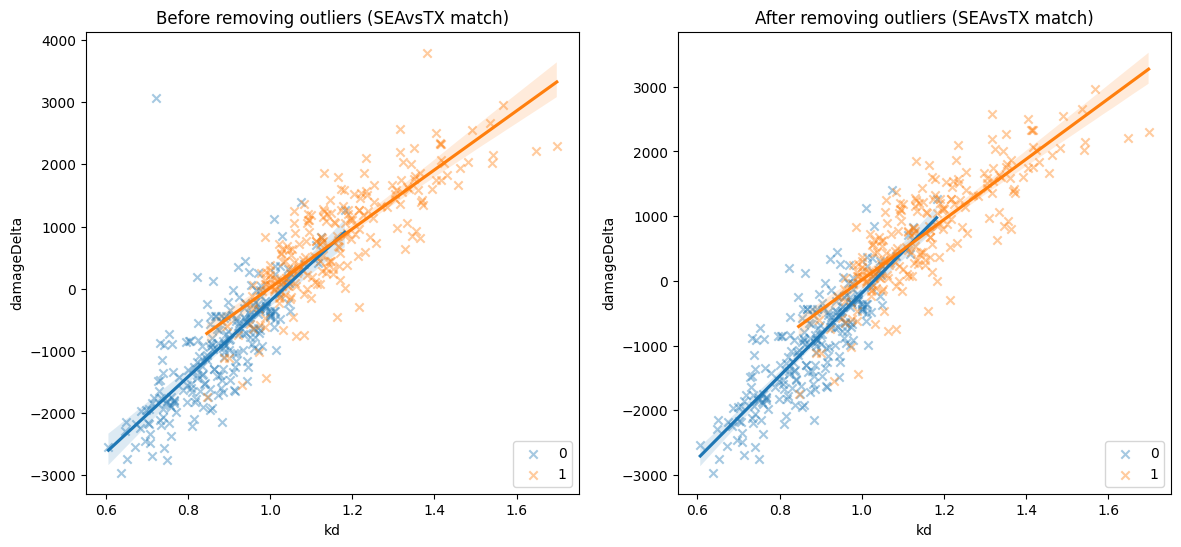

In [319]:
# Create a copy to show visually
cleaned_with_outlier = cleaned_df.copy()

# Drop row at index 426
cleaned_df.drop([426, 347], axis=0, inplace=True)

fig = plt.figure(figsize=(14, 6))
ax1, ax2 = fig.subplots(ncols=2)

# Plot old data
for outcome in [0, 1]:
    sns.regplot(ax=ax1, data=cleaned_with_outlier[cleaned_with_outlier['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome)
ax1.legend(loc="lower right");
ax1.set_title("Before removing outliers (SEAvsTX match)")

# Plot new data with the outliers removed
for outcome in [0, 1]:
    sns.regplot(ax=ax2, data=cleaned_df[cleaned_df['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome)
ax2.legend(loc="lower right");
ax2.set_title("After removing outliers (SEAvsTX match)");

From plotting kd vs damageDelta, I can see that there is a direct correlation not only between kd and damageDelta, but also with winning the map. As the kd (of the team) increases, so does the damageDelta, neaning that it is very unlikely for a team to do more damage but end up with a lower K/D ratio. As the damage and the KD increases, so does the chance of winning. On the plot, it can be seen that the teams with the highest K/D ratio's and damageDelta's are wommomg their matches, whilst the teams with lower K/D ratio's and damageDelta's are losing.

Now that these outliers have been removed, I will reset the index of the dataframe

In [320]:
#reset index
cleaned_df.reset_index(inplace=True, drop=True)
cleaned_df.head(5)

,kd,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
0,1.324324,0.229730,0.770270,0.244898,0.755102,2042.0,1
1,1.050000,0.262500,0.737500,0.309524,0.690476,538.0,1
2,1.161765,0.294118,0.705882,0.227848,0.772152,-460.0,1
3,1.217391,0.159420,0.840580,0.226190,0.773810,962.0,1
4,1.373134,0.253731,0.746269,0.206522,0.793478,1354.0,1


To explore other variables from the dataset, I will plot the remaining variables (percTradedDeaths, percUntradedDeaths, percTradedKills, percUntradedKills) against eachother to identify relationships between them. They are not expected to perform as well as damageDelta and kd in terms of correlating with the outcome of a map, as seen in the correlation matrix previously plotted.

Text(0.5, 0.98, 'relationships between variables in cleaned_df')

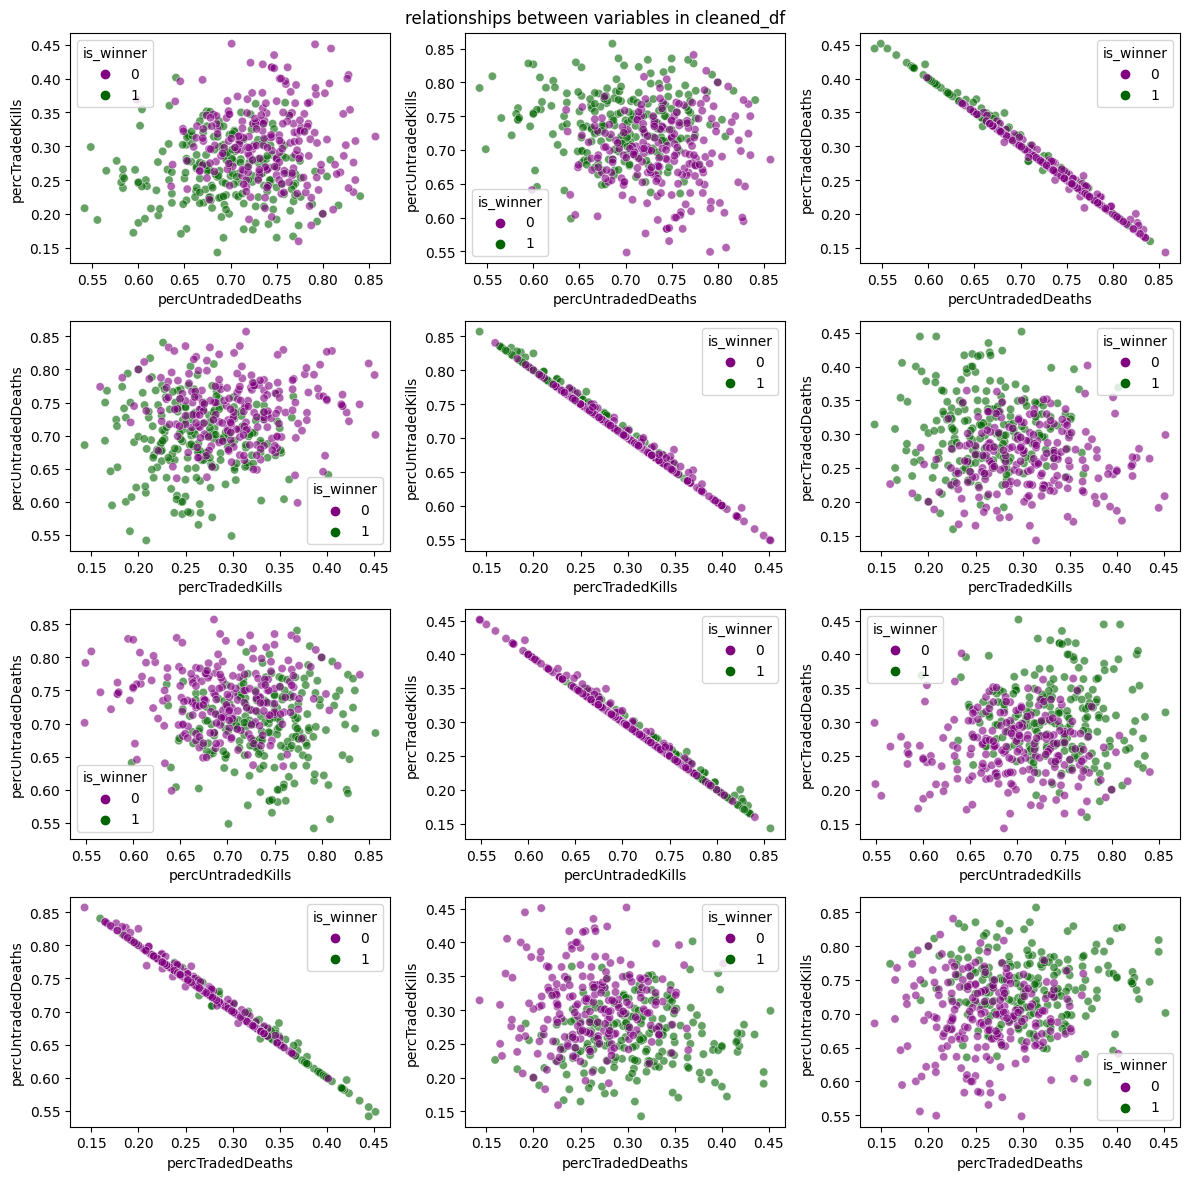

In [360]:
fig = plt.figure(figsize=(12, 12), layout='tight')
axes = fig.subplots(ncols=3, nrows=4)

variables = ['percUntradedDeaths','percTradedKills','percUntradedKills','percTradedDeaths']
for x, var in enumerate(variables):
    for y, sub_var in enumerate([i for i in variables if i != var]):
        sns.scatterplot(data=cleaned_df, x=var, y=sub_var, ax=axes[x][y], hue='is_winner', palette=['purple', 'darkgreen'], alpha=0.6)

fig.suptitle("Relationships between variables in cleaned_df");

The relationships between the following pairs 
- percTradedDeaths and percUntradedDeaths 
- percUntradedKills and percTradedKills   
are clearly shown in the graphs. This is expected as they are 'opposites' of eachother.  

Also while there isn't a strong relationship between the variables, there are distinctive groups between the winners and losers for other variable pairings.  
For example, when comparing percTradedKills and percUntradedDeaths (row 2, column 1), there is clearly a mix in the middle, with losers appearing towards the upper right of the central cluster and winners appear to the lower left